In [ ]:
import gzip
import shutil

In [ ]:
input_gz_file = 'GSE185948_count_RNA.rds.gz'
output_rds_file = 'data_for_r.rds'

# Open the compressed file and extract it
with gzip.open(input_gz_file, 'rb') as f_in, open(output_rds_file, 'wb') as f_out:
    shutil.copyfileobj(f_in, f_out)

print(f'{input_gz_file} has been successfully uncompressed to {output_rds_file}.')

In [25]:
import gzip
import shutil

input_gz_file = 'GSE185948_metadata_RNA.csv.gz'
output_csv_file = 'uncompressed_metadata.csv'

# Open the compressed file and extract it
with gzip.open(input_gz_file, 'rb') as f_in, open(output_csv_file, 'wb') as f_out:
    shutil.copyfileobj(f_in, f_out)

print(f'{input_gz_file} has been successfully uncompressed to {output_csv_file}.')

GSE185948_metadata_RNA.csv.gz has been successfully uncompressed to uncompressed_metadata.csv.


In [27]:
metadata = pd.read_csv('uncompressed_metadata.csv')

In [28]:
metadata

,name,barcode,patient,gender,disease,celltype,nCount_RNA,nFeature_RNA,UMAP_1,UMAP_2
0,PKD_ACACGCGGTATCGGTT-1_1,ACACGCGGTATCGGTT-1,PKD1,female,PKD,TAL1,1234.684629,1250,-7.416020,-6.008874
1,PKD_ACACGCGGTTTGGCTA-1_1,ACACGCGGTTTGGCTA-1,PKD1,female,PKD,PT2,1865.542588,1650,2.499409,-6.587287
2,PKD_ACACGCGTCATGTCTT-1_1,ACACGCGTCATGTCTT-1,PKD1,female,PKD,CNT_PC,1812.700523,1419,-2.254505,8.526364
3,PKD_ACACTGAAGACCCTTA-1_1,ACACTGAAGACCCTTA-1,PKD1,female,PKD,FIB,978.772591,1089,9.949437,2.086737
4,PKD_ACACTGAAGCGACAGT-1_1,ACACTGAAGCGACAGT-1,PKD1,female,PKD,PT1,2361.558871,2013,7.886921,-8.587954
...,...,...,...,...,...,...,...,...,...,...
102705,Cont_TTTGTTGCAGTTAAAG-1_5,TTTGTTGCAGTTAAAG-1,control5,female,control,DCT,2177.456940,1537,-8.038441,6.705230
102706,Cont_TTTGTTGCATATTCGG-1_5,TTTGTTGCATATTCGG-1,control5,female,control,PT1,1116.704812,984,5.658295,-6.785034
102707,Cont_TTTGTTGGTACGATTC-1_5,TTTGTTGGTACGATTC-1,control5,female,control,DCT,2156.953541,1421,-8.645567,6.688504
102708,Cont_TTTGTTGGTGCGTTTA-1_5,TTTGTTGGTGCGTTTA-1,control5,female,control,CNT_PC,1553.371592,1209,-0.795698,7.423819


R code below

In [11]:
pip install memory_profiler

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
from pyarrow.parquet import read_table
from scipy.sparse import coo_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, TransformerMixin
from memory_profiler import memory_usage
import matplotlib.pyplot as plt
import seaborn as sns

from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import GridSearchCV

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from scipy import stats
from sklearn.cluster import HDBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from scipy import stats


In [2]:
def load_data(data_path, row_info_path, column_info_path):
    # Load non_zero parquet data
    table = read_table(data_path)
    nonzero_data = table.to_pandas()
    
    # Adjust column indices to be 0-based
    nonzero_data['col_indices'] = nonzero_data['col_indices'] - 1
    
    # Load row and column index info
    rows = pd.read_csv(row_info_path)
    row_names = rows.iloc[:, 1].to_list()
    
    columns = pd.read_csv(column_info_path)
    column_names = columns.iloc[:, 1].to_list()
    
    # Convert the sparse matrix to a dense DataFrame
    sparse_matrix = coo_matrix(
        (nonzero_data['nonzero_elements'], (nonzero_data['row_indices'], nonzero_data['col_indices'])),
        shape=(len(row_names), len(column_names))
    )
    
    
   

    print('Returning sparse_matrix, column_names, and row_names')
    
    return sparse_matrix, column_names, row_names

In [3]:
data_path = 'non_zero.parquet'
row_info_path = 'row_names.csv'
column_info_path = 'col_names.csv'
#sparse_matrix = coo_matrix((data['nonzero_elements'], (data['row_indices'], data['col_indices'])))
sparse_matrix, row_names, column_names = load_data(data_path, row_info_path, column_info_path)

Returning sparse_matrix, column_names, and row_names


In [4]:
row_indices = np.arange(sparse_matrix.shape[0])

In [5]:
from sklearn.model_selection import train_test_split
sparse_train, sparse_test, train_indices, test_indices = train_test_split(
    sparse_matrix, row_indices, test_size=0.2, random_state=42
)
del sparse_matrix
del row_indices

In [6]:
train_row_names = [row_names[i] for i in train_indices]
test_row_names = [row_names[i] for i in test_indices]


In [7]:
pipeline = Pipeline([
        ('scaler', StandardScaler(with_mean = False)),
        ('pca', TruncatedSVD(n_components=2))
    ])

In [8]:
pipeline.fit(sparse_train)

# Transform the training data
pca_sparse_train = pipeline.transform(sparse_train)

In [9]:
pca_sparse_test = pipeline.transform(sparse_test)

In [44]:
train_pca_df = pd.DataFrame(pca_sparse_train, columns=["PC1", "PC2"], index=train_row_names)
test_pca_df = pd.DataFrame(pca_sparse_test, columns=["PC1", "PC2"], index=test_row_names)

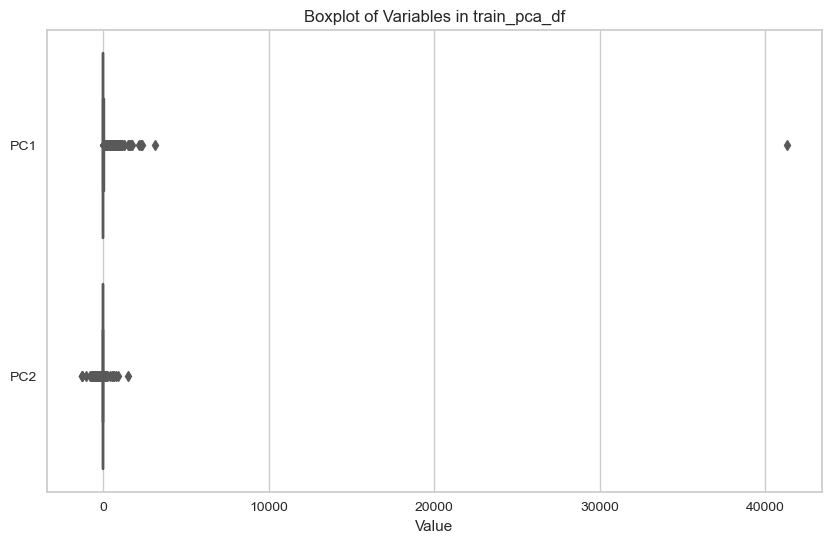

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure
plt.figure(figsize=(10, 6))

# Create a boxplot for both variables in train_pca_df
sns.boxplot(data=train_pca_df, orient="h", palette="Set2")
plt.title('Boxplot of Variables in train_pca_df')
plt.xlabel('Value')

# Show the plot
plt.show()

In [68]:
max_pc1_row = train_pca_df[train_pca_df['PC1'] == train_pca_df['PC1'].max()]

max_pc1_index = max_pc1_row.index[0]  # Assuming there is only one row with the maximum PC1 value

# Find the associated row in metadata
associated_metadata = metadata[metadata['name'] == max_pc1_index]


In [75]:
max_pc1_row

,PC1,PC2
PKD_CAGCAGCGTAGGATAT-1_2,41287.94,902.94


In [69]:
associated_metadata

,name,barcode,patient,gender,disease,celltype,nCount_RNA,nFeature_RNA,UMAP_1,UMAP_2
12312,PKD_CAGCAGCGTAGGATAT-1_2,CAGCAGCGTAGGATAT-1,PKD2,female,PKD,FIB,1931.298772,1820,6.864611,0.387584


In [77]:
import pandas as pd

# Calculate the mean for numeric columns and the most common level for categorical columns
mean_values = metadata.apply(lambda col: col.mean() if pd.api.types.is_numeric_dtype(col) else col.mode().iloc[0])

# Create a DataFrame to show the mean values
mean_metadata = pd.DataFrame(mean_values, columns=['Mean Value'])

# Set the display format for float values
pd.options.display.float_format = '{:.2f}'.format

In [78]:
mean_metadata

,Mean Value
name,Cont_AAACCCAAGACTCAAA-1_3
barcode,ACGTTCCGTGAGCGAT-1
patient,PKD2
gender,female
disease,PKD
celltype,TAL1
nCount_RNA,2817.21
nFeature_RNA,1932.71
UMAP_1,-0.00
UMAP_2,0.00


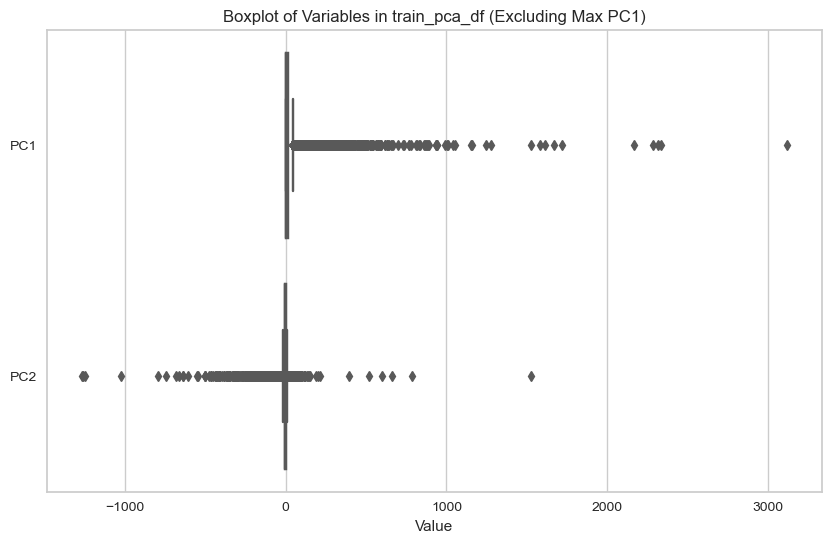

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Find the maximum value of PC1
max_pc1 = train_pca_df['PC1'].max()

# Create a new DataFrame without the rows where PC1 is equal to the maximum value
train_pca_df_filtered = train_pca_df[train_pca_df['PC1'] != max_pc1]

# Set up the figure
plt.figure(figsize=(10, 6))

# Create a boxplot for both variables in train_pca_df_filtered
sns.boxplot(data=train_pca_df_filtered, orient="h", palette="Set2")
plt.title('Boxplot of Variables in train_pca_df (Excluding Max PC1)')
plt.xlabel('Value')

# Show the plot
plt.show()

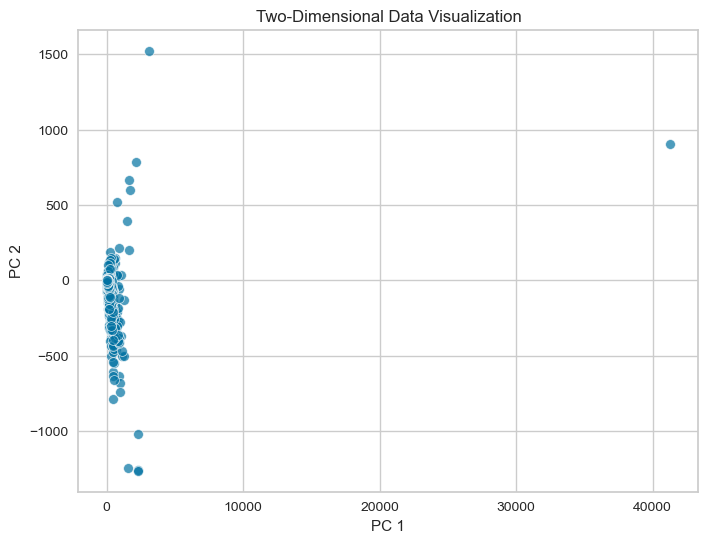

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
plt.figure(figsize=(8, 6))

# Create a scatter plot
sns.scatterplot(x='PC1', y='PC2', data=train_pca_df, marker='o', s=50, alpha=0.7)

# Add labels and title
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Two-Dimensional Data Visualization')

# Show the plot
plt.grid(True)

In [38]:
filtered_outliers_df = outliers_df[outliers_df[0] == -1]

In [13]:
train_pca_df.to_csv('train_pca_df.csv')
test_pca_df.to_csv('test_pca_df.csv')


## Clustering on the Train Data

In [57]:
def optimize_and_compare_kmeans(data, kmeans_params, alpha=0.05):
    # Perform Grid Search
    grid = GridSearchCV(KMeans(), kmeans_params, cv=3, refit=True)
    grid.fit(data)
    grid_search_estimator = grid.best_estimator_

    # Calculate silhouette scores
    default_kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(data)
    default_silhouette_score = silhouette_score(data, default_kmeans.labels_)
    grid_search_silhouette_score = silhouette_score(data, grid_search_estimator.labels_)

    # Perform a two-sample t-test only if Grid Search performs better
    if grid_search_silhouette_score > default_silhouette_score:
        t_stat, p_value = stats.ttest_ind(default_kmeans.labels_, grid_search_estimator.labels_)

        # Set the default choice to "Grid Search Estimator"
        choice = "KMeans Estimator"

        # Output informative print statements
        print("Default KMeans Silhouette Score:", default_silhouette_score)
        print("Grid Search Estimator Silhouette Score:", grid_search_silhouette_score)

        if p_value < alpha:
            choice = "Grid Search Estimator"
            print("The difference between the two groups is statistically significant.")
            print(f"Using {choice} as it performs significantly better using a threshold of alpha = .05 .")
            return choice, grid_search_estimator
        else:
            print("The difference between the two groups is not statistically significant.")
            print(f"Using {choice} as there is no significant improvement using a threshold of alpha = .05.")
            return choice, default_kmeans
    else:
        choice = "Default Parameter"
        print("Grid Search Estimator Silhouette Score:", grid_search_silhouette_score)
        print("Default KMeans Silhouette Score:", default_silhouette_score)
        print("Default Parameter has a higher Silhouette Score.")
        print("Using Default Parameter as it performs better based on Silhouette Score.")
        return choice, default_kmeans

     # Return both choice and the chosen KMeans clusterer


# Usage example with parameters
kmeans_params = {
    'n_clusters': list(range(1, 10)),
    'init': ['random', 'k-means++'],
    'n_init': [1, 5, 10],
    'max_iter': [300],
    'random_state': [0]
}
choice, k_means_estimator = optimize_and_compare_kmeans(train_pca_df, kmeans_params)

Grid Search Estimator Silhouette Score: 0.7721289327994119
Default KMeans Silhouette Score: 0.9988874801199613
Default Parameter has a higher Silhouette Score.
Using Default Parameter as it performs better based on Silhouette Score.


In [58]:
k_means_estimator

KMeans(n_clusters=2, n_init='auto', random_state=0)

In [60]:
def find_outliers_in_clusters(data, clusterer, n_neighbors=20, contamination=0.1):
    # Fit the Local Outlier Factor (LOF) model on the data
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    outliers = lof.fit_predict(data)

    # Create a DataFrame to store cluster labels and outlier labels
    cluster_outliers = pd.DataFrame({'Cluster': clusterer.labels_, 'Outlier': outliers})

    # Print the number of data points and percentage of outliers in each cluster
    cluster_info = cluster_outliers.groupby('Cluster').agg(DataPoints=('Cluster', 'count'),
                                                          PercentageOutliers=('Outlier', lambda x: (x == -1).mean() * 100))
    print("Cluster Information:")
    print(cluster_info)

    return cluster_outliers

# Example usage:
# Assuming you already have a KMeans clusterer 'chosen_kmeans' from the previous code
outliers_in_clusters = find_outliers_in_clusters(train_pca_df, k_means_estimator)
outliers_in_clusters



Cluster Information:
         DataPoints  PercentageOutliers
Cluster                                
0             22375            9.997765
1                 1          100.000000


,Cluster,Outlier
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
22371,0,1
22372,0,1
22373,0,1
22374,0,1


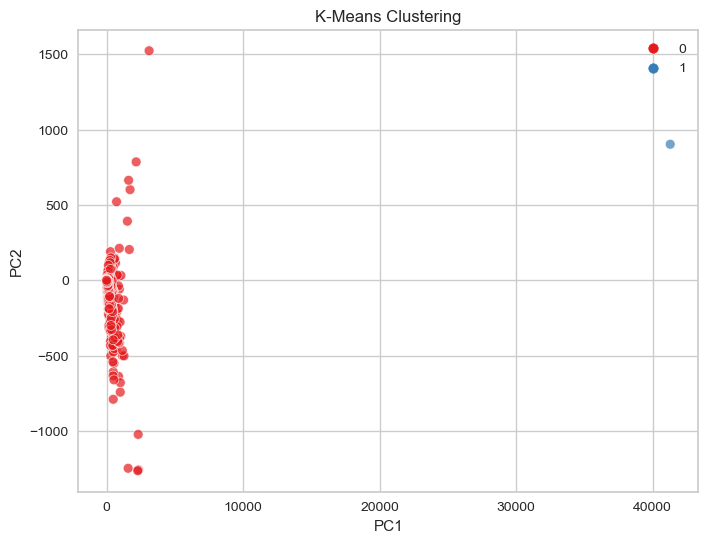

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Assuming 'train_pca_df' is your DataFrame with two columns, 'PC1' and 'PC2'
X = train_pca_df

# K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto")
y_pred = kmeans.fit_predict(X)

# Set up the figure
plt.figure(figsize=(8, 6))

# Create a scatter plot
sns.scatterplot(x='PC1', y='PC2', data=train_pca_df, hue=y_pred, palette='Set1', s=50, alpha=0.7)

# Add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clustering')

# Show the plot
plt.grid(True)
plt.show()

In [15]:
from sklearn.cluster import HDBSCAN

In [18]:
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    if len(set(labels)) == 1:
        return 0  # Silhouette score is undefined for a single cluster
    return silhouette_score(X, labels)

def optimize_and_compare_hdbscan(data, hdbscan_params, alpha=0.05):
    # Perform Grid Search
    grid_search = GridSearchCV(
        estimator=HDBSCAN(min_cluster_size=20),
        param_grid=hdbscan_params,
        scoring=silhouette_scorer,
        cv=5,
        n_jobs=-1,
    )
    grid_search.fit(data)
    grid_search_estimator = grid_search.best_estimator_

    # Calculate silhouette scores for the default and grid search estimators
    default_hdbscan = HDBSCAN(min_cluster_size=20).fit(data)
    default_labels = default_hdbscan.labels_
    default_silhouette_score = silhouette_score(data, default_labels)

    grid_search_labels = grid_search_estimator.fit_predict(data)
    grid_search_silhouette_score = silhouette_score(data, grid_search_labels)

    # Check if the grid search estimator has a higher silhouette score
    if grid_search_silhouette_score > default_silhouette_score:
        # Perform a two-sample t-test
        t_stat, p_value = stats.ttest_ind(default_labels, grid_search_labels)

        # Check if the p-value is less than the significance level
        if p_value < alpha:
            choice = "Grid Search Estimator"
        else:
            choice = "Default Parameter"
    else:
        choice = "Default Parameter"

    # Output informative print statements
    print("Default HDBSCAN Silhouette Score:", default_silhouette_score)
    print("Grid Search Estimator Silhouette Score:", grid_search_silhouette_score)

    if grid_search_silhouette_score > default_silhouette_score:
        if p_value < alpha:
            print("The difference between the two groups is statistically significant.")
            print(f"Using {choice} as it performs significantly better.")
        else:
            print("The difference between the two groups is not statistically significant.")
            print(f"Using {choice} as there is no significant improvement.")
    else:
        print("Default Parameter has a higher silhouette score. No t-test performed.")

    return choice

# Define the parameter grid for HDBSCAN
hdbscan_params = {
    'min_samples': [10, 30, 50, 60, 100],
    'min_cluster_size': [100, 200, 300, 400, 500, 600],
    'cluster_selection_method': ['eom', 'leaf'],
    'metric': ['euclidean', 'manhattan']
}

# Usage example with parameters
result = optimize_and_compare_hdbscan(train_pca_df, hdbscan_params)

Default HDBSCAN Silhouette Score: -0.7138834763437513
Grid Search Estimator Silhouette Score: -0.15317112073797398
The difference between the two groups is statistically significant.
Using Grid Search Estimator as it performs significantly better.


https://towardsdatascience.com/tuning-with-hdbscan-149865ac2970

Things to consider


1) Get the clustering to work in a pipeline
2) Are these ok default parameters
3) What to do with the test data
4) Should we be using silhoute on grid search or should i be optimizaing it differently
5) Are we normalizing it the right way? Since normalize is working along rows is this dealing with out of domain sampels? Just used standard scalar because no normalizers could work and some of them did along rows
6) Make it so it put things in folders
7) Quality check NAS? How do to this with a sparse matrix
8) Do soemthing like she did in notebook 3 to label the data set
9) Naive classifier and base? 
10) Would k-means be base what is naive?
